Min pixel value: 0.02028308057364965
Max pixel value: 0.9537864213845921


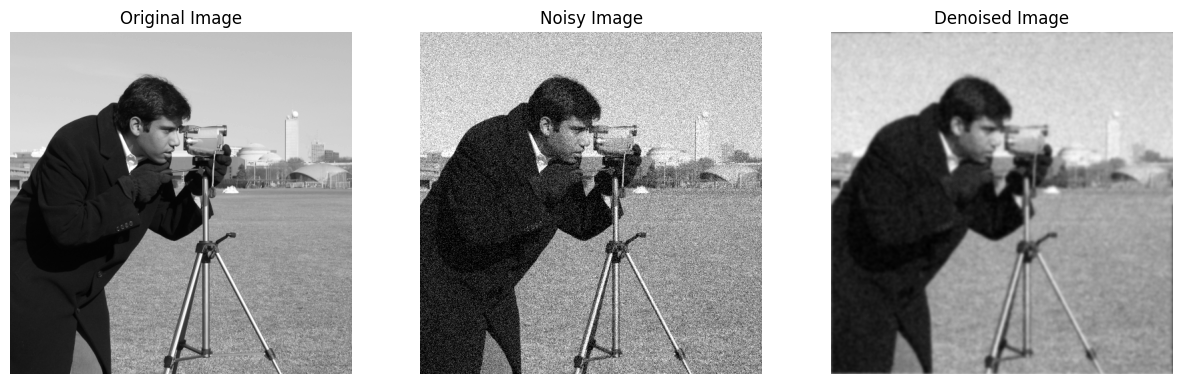

In [30]:
import numpy as np
import scipy.ndimage
from PIL import Image

def gradient(x):
    grad_x = np.roll(x, -1, axis=1) - x
    grad_y = np.roll(x, -1, axis=0) - x
    return grad_x, grad_y

def div(px, py):
    div_x = px - np.roll(px, 1, axis=1)
    div_y = py - np.roll(py, 1, axis=0)
    return div_x + div_y

def tgv_denoising(image, alpha0, alpha1, max_iter=100, tol=1e-4):
    u = image.copy()
    p = np.zeros((2, *image.shape))  # dual variable for u
    q = np.zeros((2, *image.shape))  # dual variable for v

    tau = 1.0 / (4.0 * alpha1)
    sigma = 1.0 / tau

    for i in range(max_iter):
        u_old = u.copy()

        # Compute gradients
        grad_u = np.stack(gradient(u), axis=0)
        v = u - alpha0 * div(p[0], p[1])

        # Dual update
        p += sigma * alpha0 * grad_u
        norm_p = np.maximum(1.0, np.sqrt(p[0]**2 + p[1]**2))
        p[0] /= norm_p
        p[1] /= norm_p

        grad_v = np.stack(gradient(v), axis=0)
        q += sigma * alpha1 * grad_v
        norm_q = np.maximum(1.0, np.sqrt(q[0]**2 + q[1]**2))
        q[0] /= norm_q
        q[1] /= norm_q

        # Primal update
        u += tau * div(p[0], p[1])
        u = (u + tau * image) / (1.0 + tau)

        # Check convergence
        if np.linalg.norm(u - u_old) < tol:
            break

    return u

# Example usage
if __name__ == "__main__":
    from skimage import data, img_as_float
    from skimage.util import random_noise

    # Load sample image
    image = img_as_float(data.camera())
    # noisy_image = random_noise(image, mode='s&p', amount=0.1)
    noisy_image = random_noise(image, mode='gaussian', var=0.01)

    alpha0 = 0.01
    alpha1 = 0.2

    denoised_image = tgv_denoising(noisy_image, alpha0, alpha1, max_iter=256, tol=1e-9)
    
    min_pixel = np.min(denoised_image)
    max_pixel = np.max(denoised_image)
    print(f"Min pixel value: {min_pixel}")
    print(f"Max pixel value: {max_pixel}")
    assert min_pixel >= 0 and max_pixel <= 1, "Expected pixel values in the range [0, 1]"

    denoised_image = Image.fromarray((denoised_image * 255).astype(np.uint8))
    

    # Plot the results
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(image, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')
    ax[1].imshow(noisy_image, cmap='gray')
    ax[1].set_title('Noisy Image')
    ax[1].axis('off')
    ax[2].imshow(denoised_image, cmap='gray')
    ax[2].set_title('Denoised Image')
    ax[2].axis('off')
    plt.show()